In [1]:
from langchain_community.document_loaders import DirectoryLoader

### **Markdown To Text Code**

In [2]:
import os
import re


def markdown_to_text(source_folder, destination_folder):
    # Check if the destination folder exists, if not, create it
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # JWT detection pattern
    jwt_pattern = r'(?:[A-Za-z0-9-_=]+\.){2}[A-Za-z0-9-_=]+'
    latex_pattern = r'\$\$(.*?)\$\$'
    evergreen_pattern = r'#evergreen[12]'

    # Phrases to remove
    phrases_to_remove = [
        "video links", "Video Links", "Second Brain", "brain dump", "Brain Dump",
        "upstream"
    ]

    # Iterate over all files in the source directory
    for filename in os.listdir(source_folder):
        if filename.endswith('.md'):  # Check if the file is a Markdown file
            markdown_file_path = os.path.join(source_folder, filename)
            text_file_path = os.path.join(
                destination_folder, filename.replace('.md', '.txt'))

            try:
                # Open and read the markdown file
                with open(markdown_file_path, 'r', encoding='utf-8') as file:
                    content = file.read()

                # Check if content contains #evergreen1 or #evergreen2
                if not re.search(evergreen_pattern, content):
                    continue  # Skip the file if it doesn't contain the tags

                # Convert content to lines for processing
                lines = content.splitlines()

                # Filter out unwanted lines and elements
                filtered_content = []
                for line in lines:
                    # Remove lines containing specific phrases
                    if any(phrase in line for phrase in phrases_to_remove):
                        continue

                    # Remove JWT tokens
                    line = re.sub(jwt_pattern, '', line)
                    line = re.sub(latex_pattern, '', line)

                    # Remove lines with dates or direct hashtags
                    if re.search(r'> \*\w+ on \d{4}-\d{2}-\d{2}', line) or line.strip().startswith('#'):
                        continue

                    # Remove "**links**: " and triple dashes "---"
                    line = line.replace('**links**: ', '').replace('---', '')

                    # Replace Markdown links keeping just the link name
                    line = re.sub(r'\[(.*?)\]\(.*?\)', r'\1', line)

                    # Remove raw URLs
                    line = re.sub(r'https?://\S+', '', line)

                    # Remove Markdown formatting for bold, italics, and block quotes
                    line = re.sub(r'\*\*(.*?)\*\*', r'\1', line)  # Bold
                    line = re.sub(r'\*(.*?)\*', r'\1', line)     # Italic
                    line = re.sub(r'>\s?(.*?)', r'\1', line)    # Blockquote

                    # Remove double brackets
                    line = re.sub(r'\[\[.*?\]\]', '', line)

                    # Convert headers to plain text by removing '#'
                    line = re.sub(r'^#+\s*', '', line)

                    filtered_content.append(line + '\n')

                # Write the filtered content to a text file
                with open(text_file_path, 'w', encoding='utf-8') as file:
                    file.writelines(filtered_content)

            except Exception as e:
                print(f"Failed to process {filename}: {e}")


### **markdown conversion**

In [3]:

source_folder = 'core-notes'
destination_folder = 'text-files'
markdown_to_text(source_folder, destination_folder)

### **Loader Setup**

In [4]:
loader = DirectoryLoader('text-files', glob="**/*.txt")
docs = loader.load()

### **Text Splitter Setup**

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [6]:
import tiktoken
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=75,
    length_function=len,
    is_separator_regex=False,
)

# Presumably, you have a list of documents that you want to split.
docs = text_splitter.split_documents(docs)
texts = [doc.page_content for doc in docs]



In [7]:
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    if num_tokens > 180:
        print(f"{string}\n")
    return num_tokens

In [8]:
docs = text_splitter.split_documents(docs)
chunks = [doc.page_content for doc in docs]
counts = [num_tokens_from_string(chunk) for chunk in chunks]

RMSProp also adapts the learning rates but uses a moving average of squared gradients. It solves some of Adagrad's problems like the diminishing learning rate.

Adam combines the ideas of momentum and RMSProp:

$$

m_t = \beta_1 m_{t

1} + (1

\beta_1) \nabla L(w_t)

$$

$$

v_t = \beta_2 v_{t

1} + (1

\beta_2) \nabla L(w_t)^2

$$

$$

\hat{m}_t = \frac{m_t}{1

\beta_1^t}

$$

$$

\hat{v}_t = \frac{v_t}{1

\beta_2^t}

$$

$$

w_{t+1} = w_t

\frac{\eta \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}

5. Compute Gradients for the Hidden Layer: The gradients of the loss with respect to the weights `U` and `W` are computed. For `U`, it's `dL/dU = dL/dH(3)  dH/dU = dL/dH(3)  X(3)`. For `W`, it's `dL/dW = dL/dH(3)  dH/dW = dL/dH(3)  H(2)`.

6. Repeat for t=2 and t=1: Steps 2-5 are repeated for t=2 and t=1. Note that when calculating `dL/dH(t)`, the error from the future, `dL/dH(t+1)  dH(t+1)/dH(t) = dL/dH(t+1)  W`, needs to be added.



### **Plotting the Token Count**

<function matplotlib.pyplot.show(close=None, block=None)>

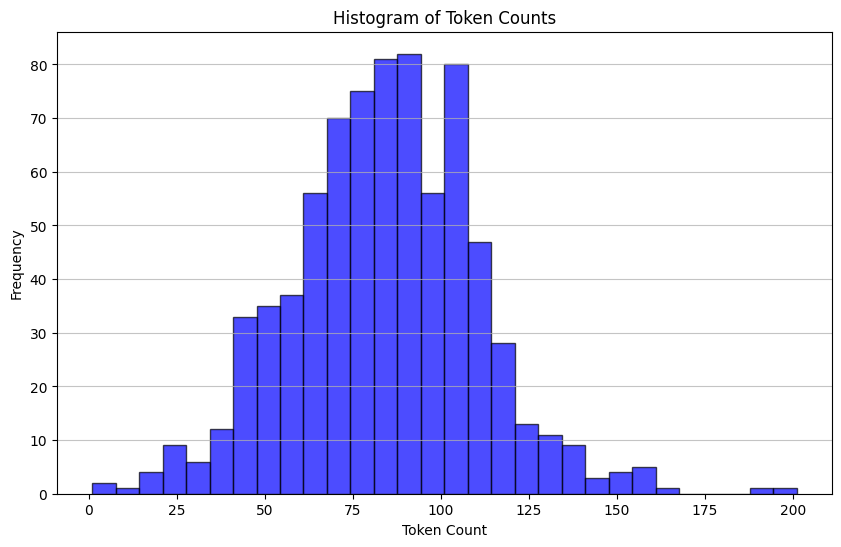

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

### **Model and Embedding Setup**

In [10]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

embedding_model = OpenAIEmbeddings()
model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

### **Pass The Text Chunks Into Embedding Space**

In [11]:
global_embeddings = [embedding_model.embed_query(txt) for txt in texts]
# print(f"embedding vectors have a length of {len(global_embeddings[0])}")

In [12]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
print(
    f"embeddings have been reduced to a dimension of {len(global_embeddings_reduced[0])}")


/Users/mcevans/Programming/knowledge-vault-assistant/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


embeddings have been reduced to a dimension of 2


### **plot embeddings in 2D space**

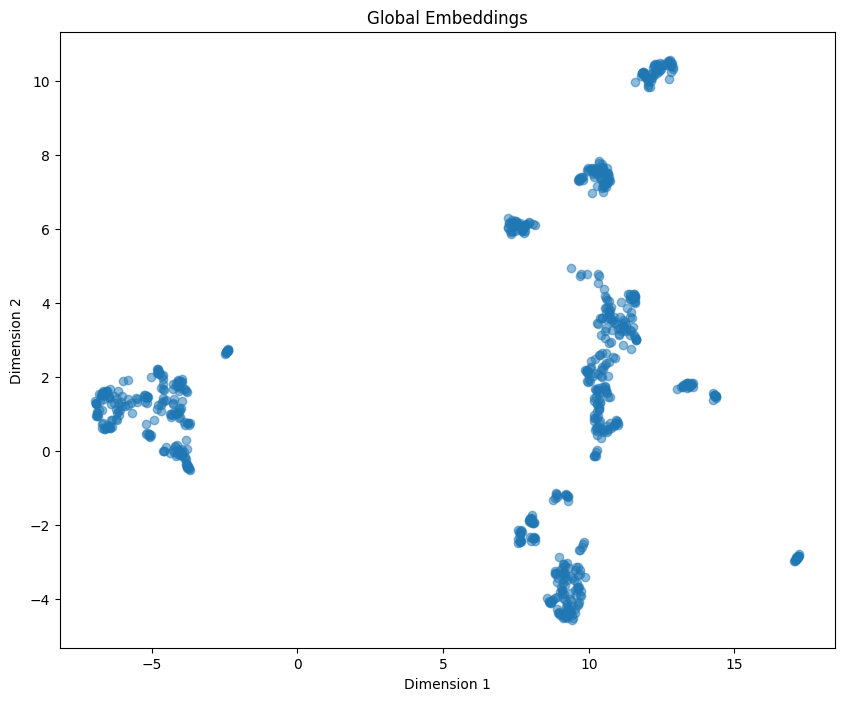

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### **define clustering functions**

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 75, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

### **Plot the Embeddings Based On Clusters**

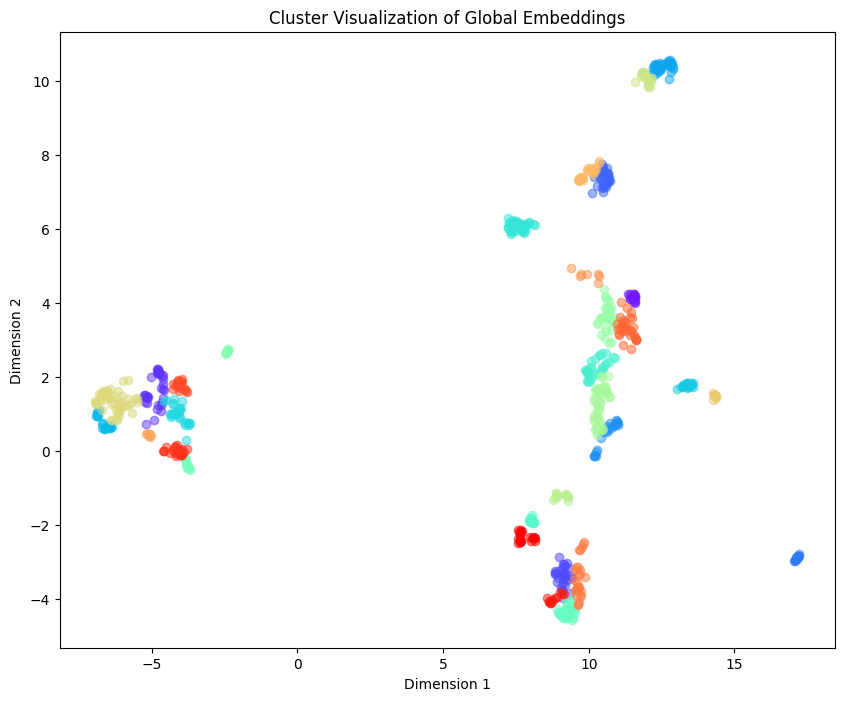

In [15]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
# plt.legend()
plt.show()

In [16]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
df.head(20)

,Text,Embedding,Cluster
0,A database migration in the context of a web a...,"[10.237138, -0.13109376]",5
1,The need for migrations arises from the fact t...,"[10.214575, -0.111960396]",5
2,The effect of a migration on existing data in ...,"[9.769183, -2.5947123]",25
3,"If the type of a column is changed, the impact...","[9.681692, -2.6822464]",25
4,"If a new table is added, this has no impact on...","[9.695279, -2.6841204]",25
5,"If you rename a column or table, the data rema...","[9.822365, -2.463258]",25
6,Also... thoroughly test your migrations in a d...,"[10.271662, 0.8926096]",17
7,```bash\n\nnpx sequelize\n\ncli init\n\n```\n\...,"[10.215848, 0.8962187]",17
8,```javascript 'use strict'; module.exports = {...,"[10.662913, 0.5977296]",5
9,cli db:migrate\n\n```\n\nThis will apply all p...,"[10.4808445, 0.5831531]",17


### **Cluster Formatting**

In [17]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [18]:
clustered_texts = format_cluster_texts(df)

In [22]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """You are an assistant to create a summary of the text input prodived. It should be human readable. It should contain a minimum of 20 words and maximum of 30 words
Text:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model | StrOutputParser()

In [23]:
labels = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    labels[cluster] = summary
labels



{5: 'Database migrations in web applications manage changes to database schemas, applying version control like Git for code. Migrations allow controlled schema changes across servers, essential for evolving software requirements.',
 25: "Migration operations in a database can have varying effects on existing data, such as adding new columns, deleting columns, or changing column types. It's crucial to backup data before running migrations.",
 17: 'Sequelize provides a utility to create migration files and apply them. Initialize your project with Sequelize CLI, create models, and run migrations for database schema changes.',
 26: 'To start with `Node.js` and `npm`, download them from the official website. Create a new project with `npm init` and install `nodemon` for automatic server restarts.',
 11: 'The text explains how to set up Sequelize with Express.js, create associations like One-To-One, One-To-Many, and Many-To-Many, handle validations, constraints, and use bcrypt for password h